<center>
<b><i><font color="Sky Blue" size="8">Test Cricket Analysis</font></i></b>
</center>


<h2><b><font color="gold">Introduction</font></b></h2>


In [1]:
# Importing required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
# Mounting Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Path for files from drive
test_ball_file = '/content/drive/MyDrive/Cricket_Project/data/model_ready/Ball By Ball/test_ball_by_ball.csv'
test_info_file = '/content/drive/MyDrive/Cricket_Project/data/model_ready/Info/test_info.csv'
test_summary_file = '/content/drive/MyDrive/Cricket_Project/data/model_ready/Summary/test_summary.csv'

# Loading the CSV's into a DataFrame
df_test_ball = pd.read_csv(test_ball_file, low_memory=False)
df_test_info = pd.read_csv(test_info_file, low_memory=False)
df_test_summary = pd.read_csv(test_summary_file, low_memory=False)

In [4]:
# Verifying the shape of Dataframes

print(f"Ball By Ball shape: {df_test_ball.shape}")
print(f"Info shape: {df_test_info.shape}")
print(f"Summary shape: {df_test_summary.shape}")

Ball By Ball shape: (1639313, 16)
Info shape: (847, 1300)
Summary shape: (847, 21)


<h2><b><font color="gold">Data Cleaning</font></b></h2>

In [5]:
# Checking for missing values in each column
missing_counts = df_test_ball.isnull().sum()
print(missing_counts)



batter                     0
bowler                     0
non_striker                0
batting_team               0
over                       0
team                       0
runs.batter                0
runs.extras                0
runs.total                 0
extras.wides               0
extras.legbyes             0
extras.byes                0
extras.noballs             0
wicket.kind          1612127
wicket.player_out    1612127
Match Id                   0
dtype: int64


In [6]:
# Remove columns with all missing values
df_test_ball.dropna(axis=1, how='all', inplace=True)


if 'batsman_runs' in df_test_ball.columns:
    df_test_ball['batsman_runs'] = df_test_ball['batsman_runs'].fillna(0)
if 'extras' in df_test_ball.columns:
    df_test_ball['extras'] = df_test_ball['extras'].fillna(0)
if 'bowler' in df_test_ball.columns:
    df_test_ball['bowler'] = df_test_ball['bowler'].fillna("Unknown")


if 'wicket.kind' in df_test_ball.columns:
    df_test_ball['is_wicket'] = df_test_ball['wicket.kind'].notnull().astype(int)
else:
    df_test_ball['is_wicket'] = 0

In [7]:
# Renaming columns for better readability

df_test_ball = df_test_ball.rename(columns={
    'runs.batter': 'batsman_runs',
    'runs.extras': 'extras',
    'runs.total': 'total_runs'
})


<h2><b><font color="gold">Data Pre-Processing</font></b></h2>

In [8]:
# Standardizing the Match ID Column Name

for df in [df_test_ball, df_test_info]:
    if 'Match Id' in df.columns:
        df.rename(columns={'Match Id': 'Match_ID'}, inplace=True)

In [9]:
# Removing unnesasary columns before merging

required_info_cols = [
    'Match_ID', 'balls_per_over', 'city', 'dates', 'event.name',
    'event.match_number', 'gender', 'match_type', 'match_type_number',
    'season', 'teams', 'player_of_match', 'outcome.winner', 'outcome.by.runs',
    'outcome.by.wickets', 'outcome.result', 'outcome.summary', 'venue'
]

# Use only columns present in your file

df_test_info = df_test_info[[col for col in required_info_cols if col in df_test_info.columns]].copy()

In [10]:
# Merging Ball data and Info data

df_test_ball = df_test_ball.merge(df_test_info, on='Match_ID', how='left')

<h2><b><font color="gold">Finding batting team and opponent team for better analysis</font></b></h2>

In [11]:
# Finding opponent team

def get_opposition(row):
    teams = row['teams']
    if isinstance(teams, list):
        pass
    elif isinstance(teams, str):
        teams = [t.strip() for t in teams.split(',')]
    else:
        return None

    if row['batting_team'] == teams[0]:
        return teams[1]
    elif row['batting_team'] == teams[1]:
        return teams[0]
    else:
        return None

df_test_ball['opposition'] = df_test_ball.apply(get_opposition, axis=1)


In [12]:
# Finding Batting Team

def find_batting_team(row):
    """
    This function returns the team name (from 'team_list') that the 'batter' plays for,
    using the players.<team_name> columns in the same DataFrame.
    """
    for t in row['team_list']:
        player_col = f"players.{t}"
        players = row.get(player_col, [])
        if isinstance(players, str):
            import ast
            try:
                players = ast.literal_eval(players)
            except Exception:
                players = [p.strip() for p in players.split(',')]
        if row['batter'] in players:
            return t
    return None

<h2><b><font color="gold">Overall analysis visualizations</font></b></h2>

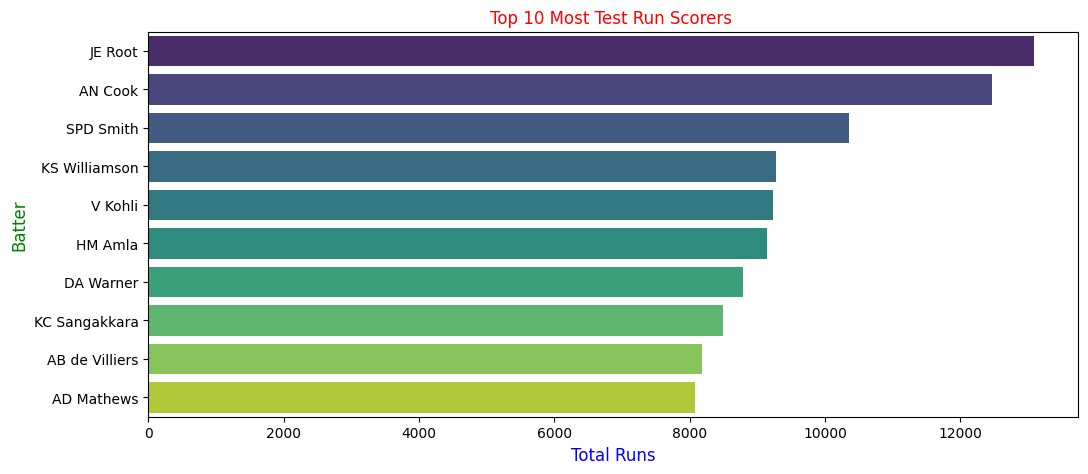

In [13]:
# Most Runs scored Battters in test

plt.figure(figsize=(12,5))
top_batsmen = df_test_ball.groupby('batter')['batsman_runs'].sum().sort_values(ascending=False).head(10)
sns.barplot(
    x=top_batsmen.values,
    y=top_batsmen.index,
    hue=top_batsmen.index,
    palette="viridis",
    legend=False
)

plt.title("Top 10 Most Test Run Scorers ", color = 'red')
plt.xlabel("Total Runs",  color='blue', fontsize=12)
plt.ylabel("Batter", color='green', fontsize=12)
plt.show()


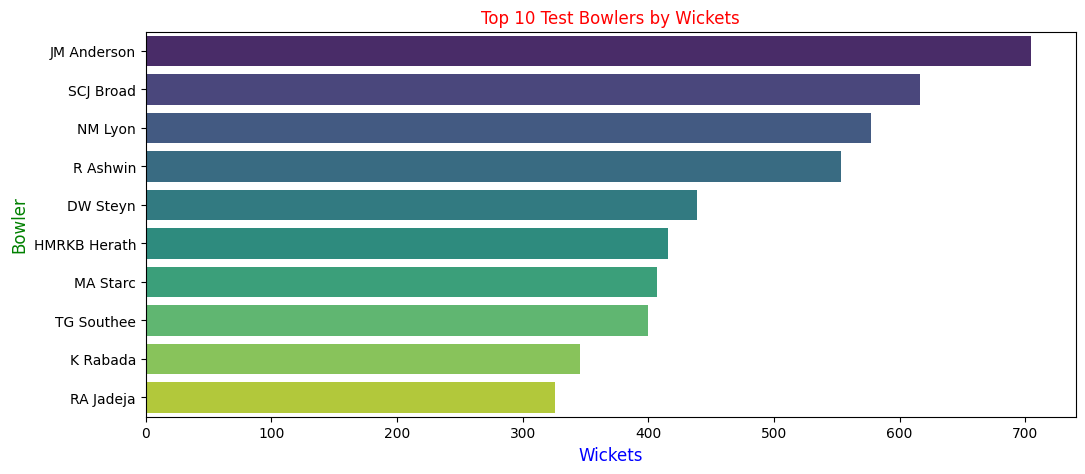

In [14]:
# Most wicket taking bowlers in test

plt.figure(figsize=(12,5))
top_bowlers = df_test_ball[df_test_ball['is_wicket']==1].groupby('bowler').size().sort_values(ascending=False).head(10)
sns.barplot(
    x=top_bowlers.values,
    y=top_bowlers.index,
    hue=top_bowlers.index,
    palette="viridis",
    legend=False
)
plt.xlabel('Wickets', color='blue', fontsize=12)
plt.ylabel('Bowler', color='green', fontsize=12)
plt.title('Top 10 Test Bowlers by Wickets', color = 'red')
plt.show()


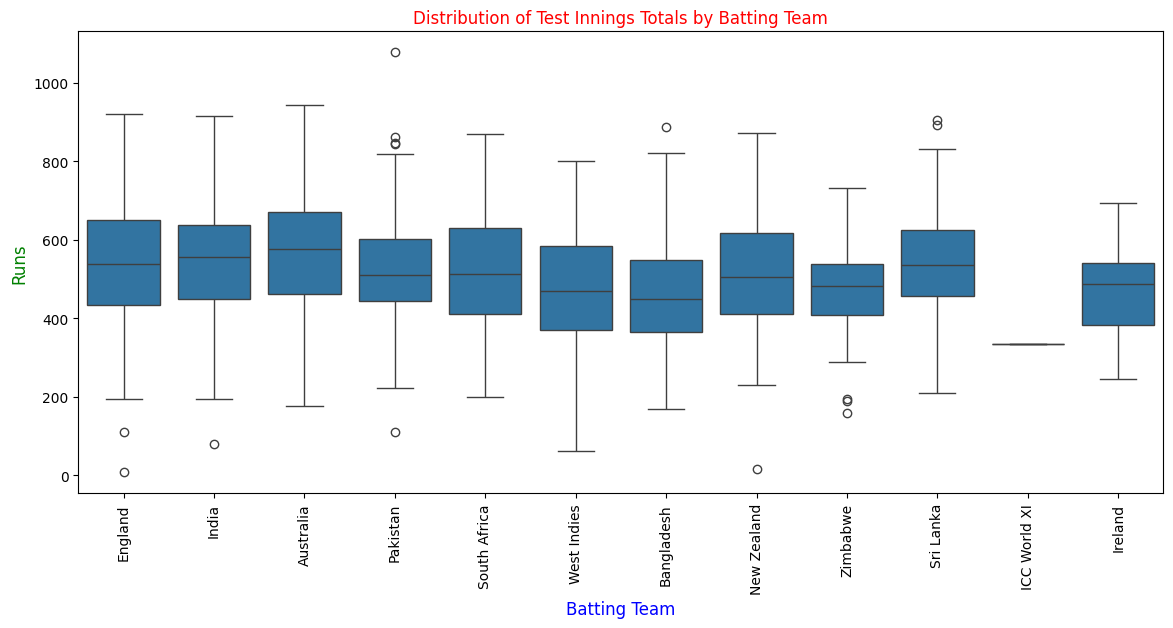

In [15]:
# Total runs scored team for match in Tests

runs_per_innings = df_test_ball.groupby(['Match_ID', 'batting_team'])['total_runs'].sum().reset_index()

plt.figure(figsize=(14,6))
sns.boxplot(x='batting_team', y='total_runs', data=runs_per_innings)
plt.title("Distribution of Test Innings Totals by Batting Team", color = 'red')
plt.xlabel("Batting Team",  color='blue', fontsize=12)
plt.ylabel("Runs", color='green', fontsize=12)
plt.xticks(rotation=90)
plt.show()


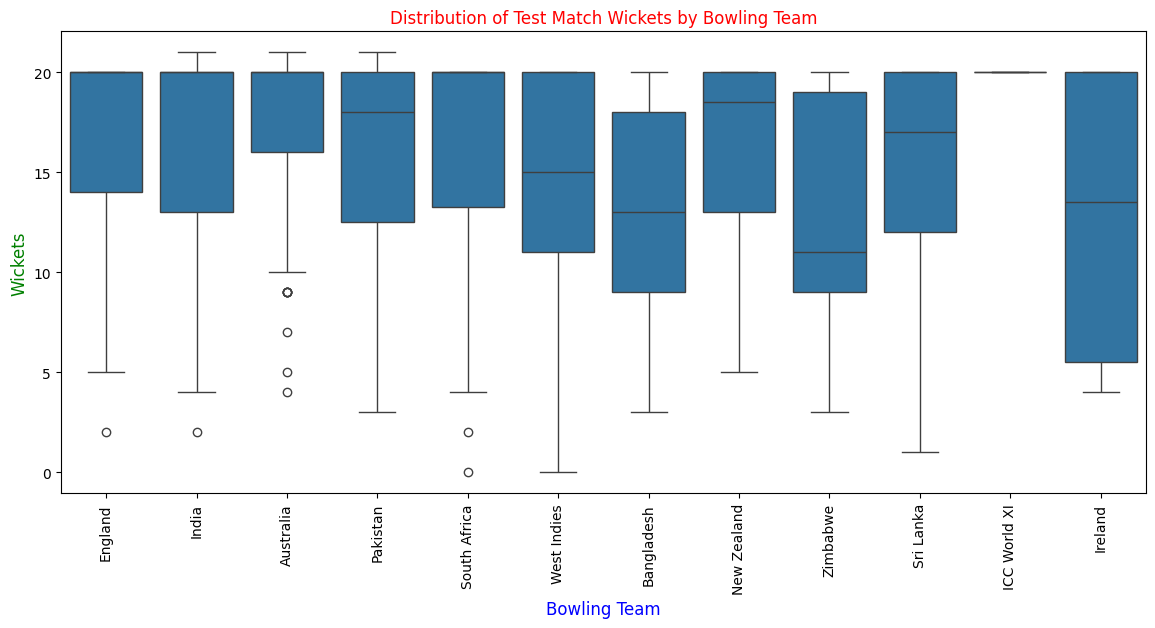

In [16]:
# Total Wickets taken by Bowling team in Match
wickets_per_innings = df_test_ball.groupby(['Match_ID', 'opposition'])['is_wicket'].sum().reset_index()

plt.figure(figsize=(14,6))
sns.boxplot(x='opposition', y='is_wicket', data=wickets_per_innings)
plt.title("Distribution of Test Match Wickets by Bowling Team", color = 'red')
plt.xlabel("Bowling Team", color='blue', fontsize=12)
plt.ylabel("Wickets", color='green', fontsize=12)
plt.xticks(rotation=90)
plt.show()


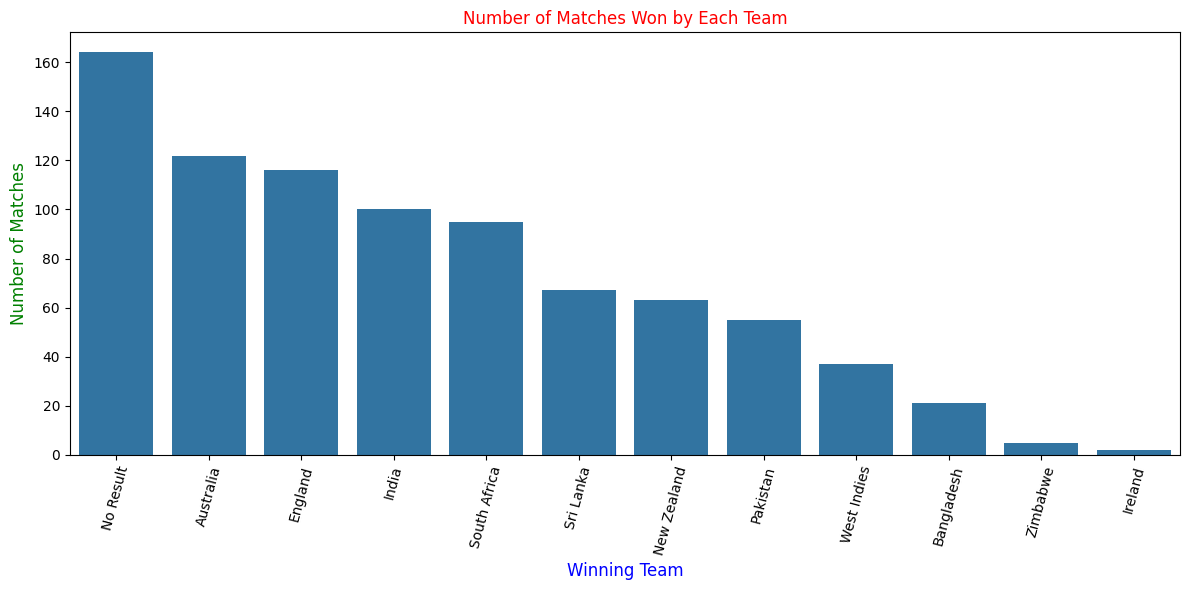

In [17]:
# Number of matches won by each team

df_test_info['outcome.winner'] = df_test_info['outcome.winner'].fillna('No Result')
plt.figure(figsize=(12,6))
winner_counts = df_test_info['outcome.winner'].value_counts().reset_index()
winner_counts.columns = ['Winner', 'Count']
ax = sns.barplot(data=winner_counts, x='Winner', y='Count')
plt.title("Number of Matches Won by Each Team", color = 'red')
plt.xlabel("Winning Team", color='blue', fontsize=12)
plt.ylabel("Number of Matches", color='green', fontsize=12)
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()


<h2><b><font color="gold">venue Mapping for further Analysis</font></b></h2>

In [18]:
# venue Mapping: Mapping all the duplicate venues

venue_mapping = {
    "Antigua Recreation Ground, St John's": "Antigua Recreation Ground",
    "Antigua Recreation Ground, St John's, Antigua": "Antigua Recreation Ground",
    "Arnos Vale Ground, Kingstown": "Arnos Vale Ground, Kingstown",
    "Arun Jaitley Stadium, Delhi": "Arun Jaitley Stadium",
    "Bangabandhu National Stadium, Dhaka": "Bangabandhu National Stadium",
    "Basin Reserve, Wellington": "Basin Reserve",
    "Bay Oval, Mount Maunganui": "Bay Oval",
    "Daren Sammy National Cricket Stadium, Gros Islet": "Daren Sammy National Cricket Stadium",
    "Daren Sammy National Cricket Stadium, Gros Islet, St Lucia": "Daren Sammy National Cricket Stadium",
    "Daren Sammy National Cricket Stadium, St Lucia": "Daren Sammy National Cricket Stadium",
    "Darren Sammy National Cricket Stadium, Gros Islet": "Daren Sammy National Cricket Stadium",
    "Bellerive Oval, Hobart": "Bellerive Oval",
    "Brisbane Cricket Ground, Woolloongabba": "Brisbane Cricket Ground",
    "Brisbane Cricket Ground, Woolloongabba, Brisbane": "Brisbane Cricket Ground",
    "Edgbaston, Birmingham": "Edgbaston",
    "Gaddafi Stadium, Lahore": "Gaddafi Stadium",
    "Green Park, Kanpur": "Green Park",
    "Hagley Oval, Christchurch": "Hagley Oval",
    "Headingley, Leeds": "Headingley",
    "Himachal Pradesh Cricket Association Stadium, Dharamsala": "Himachal Pradesh Cricket Association Stadium",
    "Holkar Cricket Stadium, Indore": "Holkar Cricket Stadium",
    "Iqbal Stadium, Faisalabad": "Iqbal Stadium",
    "JSCA International Stadium Complex, Ranchi": "JSCA International Stadium Complex",
    "Kennington Oval, London": "Kennington Oval",
    "Kensington Oval, Barbados": "Kensington Oval",
    "Kensington Oval, Bridgetown": "Kensington Oval",
    "Kensington Oval, Bridgetown, Barbados": "Kensington Oval",
    "Kingsmead, Durban": "Kingsmead",
    "Lord's, London": "Lord's",
    "M Chinnaswamy Stadium, Bangalore": "M Chinnaswamy Stadium",
    "M Chinnaswamy Stadium, Bengaluru": "M Chinnaswamy Stadium",
    "M.Chinnaswamy Stadium": "M Chinnaswamy Stadium",
    "MA Aziz Stadium, Chittagong": "MA Aziz Stadium",
    "MA Chidambaram Stadium, Chepauk": "MA Chidambaram Stadium",
    "MA Chidambaram Stadium, Chepauk, Chennai": "MA Chidambaram Stadium",
    "Maharashtra Cricket Association Stadium, Pune": "Maharashtra Cricket Association Stadium",
    "National Cricket Stadium, St George's, Grenada": "National Cricket Stadium, St George's",
    "National Stadium, Karachi": "National Stadium",
    "New Wanderers Stadium, Johannesburg": "New Wanderers Stadium",
    "Newlands, Cape Town": "Newlands",
    "Old Trafford, Manchester": "Old Trafford",
    "Providence Stadium, Guyana": "Providence Stadium",
    "Punjab Cricket Association IS Bindra Stadium, Mohali, Chandigarh": "Punjab Cricket Association IS Bindra Stadium, Mohali",
    "Punjab Cricket Association Stadium, Mohali, Chandigarh": "Punjab Cricket Association Stadium, Mohali",
    "Queen's Park Oval, Port of Spain, Trinidad": "Queen's Park Oval, Port of Spain",
    "Queens Sports Club, Bulawayo": "Queens Sports Club",
    "R.Premadasa Stadium": "R Premadasa Stadium",
    "R.Premadasa Stadium, Khettarama": "R Premadasa Stadium",
    "Rajiv Gandhi International Stadium, Uppal, Hyderabad": "Rajiv Gandhi International Stadium, Uppal",
    "Sabina Park, Jamaica": "Sabina Park, Kingston",
    "Sabina Park, Kingston, Jamaica": "Sabina Park, Kingston",
    "Sardar Patel Stadium, Motera": "Sardar Patel Stadium",
    "Saurashtra Cricket Association Stadium, Rajkot": "Saurashtra Cricket Association Stadium",
    "Seddon Park, Hamilton": "Seddon Park",
    "Sinhalese Sports Club Ground, Colombo": "Sinhalese Sports Club Ground",
    "Sir Vivian Richards Stadium, Antigua": "Sir Vivian Richards Stadium",
    "Sir Vivian Richards Stadium, North Sound": "Sir Vivian Richards Stadium",
    "Sir Vivian Richards Stadium, North Sound, Antigua": "Sir Vivian Richards Stadium",
    "St George's Park, Gqeberha": "St George's Park",
    "St George's Park, Port Elizabeth": "St George's Park",
    "SuperSport Park, Centurion": "SuperSport Park",
    "The Rose Bowl, Southampton": "The Rose Bowl",
    "The Wanderers Stadium, Johannesburg": "The Wanderers Stadium",
    "Trent Bridge, Nottingham": "Trent Bridge",
    "Vidarbha Cricket Association Stadium, Jamtha, Nagpur": "Vidarbha Cricket Association Stadium, Jamtha",
    "Wankhede Stadium, Mumbai": "Wankhede Stadium",
    "Warner Park, Basseterre": "Warner Park",
    "Western Australia Cricket Association Ground, Perth": "Western Australia Cricket Association Ground",
    "Windsor Park, Roseau, Dominica": "Windsor Park, Roseau",
    "Zahur Ahmed Chowdhury Stadium, Chattogram": "Zahur Ahmed Chowdhury Stadium",
    "Zohur Ahmed Chowdhury Stadium": "Zahur Ahmed Chowdhury Stadium",
}


In [19]:
# Adding the venue column into data from venue mapping

df_test_ball['venue'] = df_test_ball['venue'].map(lambda x: venue_mapping.get(x, x))

<h2><b><font color="gold">Batting Metrics of a Batter</font></b></h2>

In [20]:
# Basic batting metrics by batter

test_batting_stats = (
    df_test_ball.groupby('batter').agg(
        runs_scored = ('batsman_runs', 'sum'),
        balls_faced = ('batsman_runs', 'count'),
        fours = ('batsman_runs', lambda x: (x == 4).sum()),
        sixes = ('batsman_runs', lambda x: (x == 6).sum()),
        dismissals = ('is_wicket', 'sum')
    ).reset_index()
)

In [21]:
# Advanced metrics: high score, 50s, 100s, 200s, std, from per-innings scores

test_innings_scores = df_test_ball.groupby(['batter', 'Match_ID'])['batsman_runs'].sum().reset_index()
advanced = (
    test_innings_scores.groupby('batter').agg(
        high_score = ('batsman_runs', 'max'),
        fifties = ('batsman_runs', lambda x: ((x >= 50) & (x < 100)).sum()),
        hundreds = ('batsman_runs', lambda x: ((x >= 100) & (x < 200)).sum()),
        double_hundreds = ('batsman_runs', lambda x: (x >= 200).sum()),
        score_std = ('batsman_runs', 'std')
    ).reset_index()
)

# Round off score_std with 2 decimal values
advanced['score_std'] = advanced['score_std'].round(2)


In [22]:
# Merging Basic Metrics and Adavance Metrics

test_batting_stats = test_batting_stats.merge(advanced, on='batter', how='left')


In [23]:
# Post-processing adding strike rate, batting average to the dataframe

test_batting_stats['strike_rate'] = (test_batting_stats['runs_scored'] / test_batting_stats['balls_faced'] * 100).replace([np.inf, np.nan], 0).round(2)
test_batting_stats['batting_average'] = (test_batting_stats['runs_scored'] / test_batting_stats['dismissals']).replace([np.inf, np.nan], 0).round(2)

In [24]:
# Finding Recent Form from last 5 matches
N = 5
test_innings_scores['recent_form_runs'] = (
    test_innings_scores.groupby('batter')['batsman_runs']
    .transform(lambda x: x.shift(1).rolling(window=N, min_periods=1).mean())
)
test_innings_scores['career_avg_runs'] = (
    test_innings_scores.groupby('batter')['batsman_runs'].transform(lambda x: x.expanding().mean())
)

<h2><b><font color="gold">Metrics of Batter Vs Opponent</font></b></h2>

In [25]:
# Metrics of Batter vs Opponent

test_batter_vs_opp = (
    df_test_ball.groupby(['batter', 'opposition']).agg(
        innings_played=('Match_ID', pd.Series.nunique),
        runs_scored=('batsman_runs', 'sum'),
        balls_faced=('batsman_runs', 'count'),
        dismissals=('is_wicket', 'sum')
    ).reset_index()
)
test_batter_vs_opp['batting_average'] = (test_batter_vs_opp['runs_scored'] /test_batter_vs_opp['dismissals']).replace([np.inf, np.nan], 0).round(2)
test_batter_vs_opp['strike_rate'] = (test_batter_vs_opp['runs_scored'] / test_batter_vs_opp['balls_faced'] * 100).replace([np.inf, np.nan], 0).round(2)


In [26]:
# Adding Boundary Percentage & Balls per Boundary to the dataframe

test_batting_stats['boundary_pct'] = (
    (test_batting_stats['fours'] + test_batting_stats['sixes']) / test_batting_stats['balls_faced'] * 100
).replace([np.inf, np.nan], 0).round(2)

test_batting_stats['balls_per_boundary'] = (
    test_batting_stats['balls_faced'] / (test_batting_stats['fours'] + test_batting_stats['sixes'])
).replace([np.inf, np.nan], 0).round(2)


In [27]:
# Wide Format Batter Overall Average Metrics and Average Vs Opponent

test_batter_vs_opp_pivot = (
    test_batter_vs_opp.pivot(index='batter', columns='opposition', values='batting_average')
    .add_prefix('avg_vs_')
    .reset_index()
)
batting_summary = test_batting_stats.merge(test_batter_vs_opp_pivot, on='batter', how='left')


<h2><b><font color="gold">Metrics of Batter Vs venue</font></b></h2>

In [28]:
# Runs for each batter at each venue

test_innings_scores = (
    df_test_ball.groupby(['batter', 'venue', 'Match_ID'])['batsman_runs']
    .sum()
    .reset_index()
)


In [29]:
# Counting 50s and 100s at each venue for each batter

test_fifty_hundred_stats = (
    test_innings_scores.groupby(['batter', 'venue'])
    .agg(
        fifties=('batsman_runs', lambda x: ((x >= 50) & (x < 100)).sum()),
        hundreds=('batsman_runs', lambda x: ((x >= 100) & (x < 200)).sum()),
        double_hundreds=('batsman_runs', lambda x: (x >= 200).sum())
    )
    .reset_index()
)

In [30]:
# Core Batting Stats by batter and venue

test_batter_vs_venue = (
    df_test_ball.groupby(['batter', 'venue']).agg(
        innings_played=('Match_ID', pd.Series.nunique),
        runs_scored=('batsman_runs', 'sum'),
        balls_faced=('batsman_runs', 'count'),
        dismissals=('is_wicket', 'sum'),
        fours=('batsman_runs', lambda x: (x == 4).sum()),
        sixes=('batsman_runs', lambda x: (x == 6).sum())
    ).reset_index()
)


In [31]:
# Adding 50s/100s/200s to the venue stats df

test_batter_vs_venue = test_batter_vs_venue.merge(
    test_fifty_hundred_stats, on=['batter', 'venue'], how='left'
)

In [32]:
# Advanced Batting Metrics

# Finding Batting Average for each venue

test_batter_vs_venue['batting_average'] = (
    test_batter_vs_venue['runs_scored'] / test_batter_vs_venue['dismissals']
).replace([np.inf, np.nan], 0).round(2)

# Finding Strike Rate for each venue

test_batter_vs_venue['strike_rate'] = (
    test_batter_vs_venue['runs_scored'] / test_batter_vs_venue['balls_faced'] * 100
).replace([np.inf, np.nan], 0).round(2)

# Filling NaN for fifties/hundreds/double_hundreds ----
test_batter_vs_venue[['fifties', 'hundreds', 'double_hundreds']] = test_batter_vs_venue[[
    'fifties', 'hundreds', 'double_hundreds'
]].fillna(0).astype(int)

<h2><b><font color="gold">Bowling Metrics for Bowler</font></b></h2>

In [33]:
# A maiden = an over with total_runs == 0 for a bowler in a match

test_overs_summary = (
    df_test_ball.groupby(['bowler', 'Match_ID', 'batting_team', 'over'])
    .agg(total_runs_in_over=('total_runs', 'sum'))
    .reset_index()
)
test_overs_summary['is_maiden'] = (test_overs_summary['total_runs_in_over'] == 0).astype(int)

test_maidens_by_bowler = (
    test_overs_summary.groupby('bowler')['is_maiden']
    .sum()
    .reset_index()
    .rename(columns={'is_maiden': 'maidens'})
)

In [34]:
# Bowling Metrics for bowler

test_agg_dict = {
    'balls_bowled': ('bowler', 'count'),
    'runs_conceded': ('total_runs', 'sum'),
    'wickets': ('is_wicket', 'sum'),
    'fours_conceded': ('batsman_runs', lambda x: (x == 4).sum()),
    'sixes_conceded': ('batsman_runs', lambda x: (x == 6).sum()),
}

test_bowling_stats = df_test_ball.groupby('bowler').agg(**test_agg_dict).reset_index()
test_bowling_stats = test_bowling_stats.merge(test_maidens_by_bowler, on='bowler', how='left')
test_bowling_stats['maidens'] = test_bowling_stats['maidens'].fillna(0).astype(int)

In [35]:
# Per-Innings Bowling Summary

test_innings_bowling = (
    df_test_ball.groupby(['bowler', 'Match_ID', 'batting_team'])
    .agg(
        runs_conceded=('total_runs', 'sum'),
        wickets=('is_wicket', 'sum'),
        balls_bowled=('bowler', 'count')
    ).reset_index()
)

In [36]:
# Best innings figures (most wickets and then fewest runs)

test_best_innings = (
    test_innings_bowling.loc[
        test_innings_bowling.groupby('bowler')['wickets'].idxmax()
    ][['bowler', 'wickets', 'runs_conceded']]
    .rename(columns={'wickets': 'best_innings_wickets', 'runs_conceded': 'best_innings_runs_conceded'})
)

In [37]:
# 5WI, std dev
advanced_bowl = (
    test_innings_bowling.groupby('bowler').agg(
        five_wicket_hauls=('wickets', lambda x: (x >= 5).sum()),
        wickets_std=('wickets', 'std')
    ).reset_index()
)
advanced_bowl['wickets_std'] = advanced_bowl['wickets_std'].replace([np.inf, np.nan], 0).round(2)

In [38]:
# 10-wicket matches: sum wickets by match, count where greater than or equal to 10

test_ten_wicket_matches = (
    test_innings_bowling.groupby(['bowler', 'Match_ID'])['wickets'].sum().reset_index()
)
test_ten_wicket_count = (
    test_ten_wicket_matches.groupby('bowler')['wickets'].apply(lambda x: (x >= 10).sum()).reset_index().rename(columns={'wickets': 'ten_wicket_matches'})
)


In [39]:
# Merging advanced metrics

advanced_bowl = advanced_bowl.merge(test_best_innings, on='bowler', how='left')
advanced_bowl = advanced_bowl.merge(test_ten_wicket_count, on='bowler', how='left')

In [40]:
# Merging Basic and Advanced metrics

test_bowling_stats = test_bowling_stats.merge(advanced_bowl, on='bowler', how='left')
test_bowling_stats['best_innings_wickets'] = test_bowling_stats['best_innings_wickets'].fillna(0).astype(int)

In [41]:
# Post-Processing Metrics: Bowling Average, Strike Rate, Economy

# Finding Bowling Average

test_bowling_stats['bowling_average'] = (
    test_bowling_stats['runs_conceded'] / test_bowling_stats['wickets']
).replace([np.inf, np.nan], 0).round(2)


# Finding Bowler Strike rate

test_bowling_stats['strike_rate'] = (
    test_bowling_stats['balls_bowled'] / test_bowling_stats['wickets']
).replace([np.inf, np.nan], 0).round(2)


# Finding Bowler Economy

test_bowling_stats['economy'] = (
    test_bowling_stats['runs_conceded'] / test_bowling_stats['balls_bowled'] * 6
).replace([np.inf, np.nan], 0).round(2)


# Finding Wicket per balls

test_bowling_stats['balls_per_wicket'] = (
    test_bowling_stats['balls_bowled'] / test_bowling_stats['wickets']
).replace([np.inf, np.nan], 0).round(2)


#Finding Boundaary Percentage

test_bowling_stats['boundary_pct'] = (
    (test_bowling_stats['fours_conceded'] + test_bowling_stats['sixes_conceded']) /
    test_bowling_stats['balls_bowled'] * 100
).replace([np.inf, np.nan], 0).round(2)

<h2><b><font color="gold">Bowler Vs Opponent Analysis</font></b></h2>

In [42]:
# Bowler vs Opposition Analysis

test_bowler_vs_opp = (
    df_test_ball.groupby(['bowler', 'opposition']).agg(
        matches=('Match_ID', pd.Series.nunique),
        balls_bowled=('bowler', 'count'),
        runs_conceded=('total_runs', 'sum'),
        wickets=('is_wicket', 'sum'),
    ).reset_index()
)


In [43]:
# Adding Bowling_Avg, Balls_Bowled, Economy fields to the dataframe

test_bowler_vs_opp['bowling_average'] = (
    test_bowler_vs_opp['runs_conceded'] / test_bowler_vs_opp['wickets']
).replace([np.inf, np.nan], 0).round(2)
test_bowler_vs_opp['strike_rate'] = (
    test_bowler_vs_opp['balls_bowled'] / test_bowler_vs_opp['wickets']
).replace([np.inf, np.nan], 0).round(2)
test_bowler_vs_opp['economy'] = (
    test_bowler_vs_opp['runs_conceded'] / test_bowler_vs_opp['balls_bowled'] * 6
).replace([np.inf, np.nan], 0).round(2)

In [44]:
# Wide Format (Pivot for Averages by Opposition)
test_bowler_vs_opp_pivot = (
    test_bowler_vs_opp.pivot(index='bowler', columns='opposition', values='bowling_average')
    .add_prefix('avg_vs_')
    .reset_index()
)
test_bowling_summary = test_bowling_stats.merge(test_bowler_vs_opp_pivot, on='bowler', how='left')


<h2><b><font color="gold"> Bowler Vs venue Analysis</font></b></h2>

In [45]:
# Bowler Vs venue

test_bowler_vs_venue = (
    df_test_ball.groupby(['bowler', 'venue']).agg(
        matches=('Match_ID', pd.Series.nunique),
        balls_bowled=('bowler', 'count'),
        runs_conceded=('total_runs', 'sum'),
        wickets=('is_wicket', 'sum'),
        fours_conceded=('batsman_runs', lambda x: (x == 4).sum()),
        sixes_conceded=('batsman_runs', lambda x: (x == 6).sum())
    ).reset_index()
)

In [46]:
# Adding Bowling_Avg, Strike rate, Economy fields to the dataframe

test_bowler_vs_venue['bowling_average'] = (
    test_bowler_vs_venue['runs_conceded'] / test_bowler_vs_venue['wickets']
).replace([np.inf, np.nan], 0).round(2)
test_bowler_vs_venue['strike_rate'] = (
    test_bowler_vs_venue['balls_bowled'] / test_bowler_vs_venue['wickets']
).replace([np.inf, np.nan], 0).round(2)
test_bowler_vs_venue['economy'] = (
    test_bowler_vs_venue['runs_conceded'] / test_bowler_vs_venue['balls_bowled'] * 6
).replace([np.inf, np.nan], 0).round(2)

In [47]:
# Finding Recent Form from last 5 matches

N = 5
test_innings_bowling['recent_form_wickets'] = (
    test_innings_bowling.groupby('bowler')['wickets']
    .transform(lambda x: x.shift(1).rolling(window=N, min_periods=1).mean())
)
test_innings_bowling['career_avg_wickets'] = (
    test_innings_bowling.groupby('bowler')['wickets'].transform(lambda x: x.expanding().mean())
)